In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from config import Config
from model import get_model
from poison_detector import PoisonDetector
from data_loader import get_dataloaders
from adversarial_attacks import AdversarialAttacks
import os

sns.set(style="white")
device = Config.DEVICE
print(f"Using device: {device}")

Using device: cuda


In [2]:
# 1. Load Classifier (Needed for Generating Attacks)
model = get_model(pretrained=False)
if os.path.exists("global_model_final.pth"):
    model.load_state_dict(torch.load("global_model_final.pth", map_location=device))
    print("✓ Classifier loaded.")
else:
    print("⚠️ global_model_final.pth not found!")
model.eval()

# 2. Load Poison Detector
detector = PoisonDetector(model)
if os.path.exists("poison_detector.pth"):
    detector.load_detector("poison_detector.pth")
    print(f"✓ Detector loaded. Threshold: {detector.threshold:.5f}")
    print(f"  - Mean Error: {detector.mean_error:.5f}")
    print(f"  - Std Error:  {detector.std_error:.5f}")
else:
    print("⚠️ poison_detector.pth not found!")

# IMPORTANT: Ensure Eval Mode
detector.detector.eval()
detector.feature_extractor.eval()

✓ Classifier loaded.
✓ Autoencoder chargé (Seuil CORRIGÉ: 0.020000)
✓ Detector loaded. Threshold: 0.02000
  - Mean Error: 0.01250
  - Std Error:  0.00548


ChestXRayModel(
  (backbone): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): FusedMBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
          )
          (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        )
        (1): FusedMBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (1): BatchNor

In [3]:
test_loader, _ = get_dataloaders(Config.DATASET_PATH)
data_iter = iter(test_loader)
images, labels = next(data_iter)
images = images.to(device)
labels = labels.to(device)

print(f"Loaded batch of {len(images)} images.")

Loaded batch of 32 images.


In [4]:
print("Generating PGD Attacks (Epsilon=0.15)...")
model.eval()
adv_images = AdversarialAttacks.pgd_attack(model, images, labels, epsilon=0.15)
print("Attacks generated.")

Generating PGD Attacks (Epsilon=0.15)...
Attacks generated.


In [5]:
def visualize_detection(index):
    # Get samples
    # Using clone/detach to be safe for gradient computation
    clean_img = images[index].unsqueeze(0).to(device)
    adv_img = adv_images[index].unsqueeze(0).to(device)
    
    # Feature Extraction Saliency Logic
    def get_saliency(img_tensor):
        img_tensor.requires_grad = True
        
        # FORCE EVAL MODE (Just in case)
        detector.detector.eval()
        detector.feature_extractor.eval()
        
        # Forward (Feature Space)
        features = detector.feature_extractor.get_features(img_tensor)
        reconstructed = detector.detector(features)
        
        # Error
        error = ((features - reconstructed) ** 2).mean()
        
        # Backward to get gradient on image
        detector.feature_extractor.zero_grad()
        detector.detector.zero_grad()
        error.backward()
        
        # Saliency = Max over channels of absolute gradient
        if img_tensor.grad is not None:
            saliency = img_tensor.grad.abs().max(dim=1)[0].squeeze().cpu().numpy()
        else:
            saliency = np.zeros(img_tensor.shape[2:])
            
        return saliency, error.item()

    # Clean Saliency
    saliency_clean, clean_err = get_saliency(clean_img.clone().detach())
    
    # Adv Saliency
    saliency_adv, adv_err = get_saliency(adv_img.clone().detach())
    
    # Helper to convert tensor to numpy image
    def to_img(t):
        # Denormalize roughly for visualization (assuming ImageNet stats)
        mean = torch.tensor([0.485, 0.456, 0.406]).to(device).view(1,3,1,1)
        std = torch.tensor([0.229, 0.224, 0.225]).to(device).view(1,3,1,1)
        t = t * std + mean
        return t.clamp(0, 1).cpu().squeeze(0).permute(1, 2, 0).numpy()

    # Plotting
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    
    # Row 1: Clean
    axs[0, 0].imshow(to_img(images[index].unsqueeze(0).to(device)))
    axs[0, 0].set_title(f"Clean Image (True: {labels[index].item()})")
    axs[0, 0].axis('off')
    
    im1 = axs[0, 1].imshow(saliency_clean, cmap='hot')
    axs[0, 1].set_title(f"Clean Anomaly Map (Err: {clean_err:.4f})")
    axs[0, 1].axis('off')
    plt.colorbar(im1, ax=axs[0, 1])

    # Row 2: Adversarial
    axs[1, 0].imshow(to_img(adv_images[index].unsqueeze(0).to(device)))
    axs[1, 0].set_title("Adversarial Image")
    axs[1, 0].axis('off')
    
    im2 = axs[1, 1].imshow(saliency_adv, cmap='hot')
    
    status = "DETECTED" if adv_err > detector.threshold else "MISSED"
    color = "green" if status == "DETECTED" else "red"
    axs[1, 1].set_title(f"Attack Anomaly Map (Err: {adv_err:.4f}) [{status}]", color=color, fontweight='bold')
    axs[1, 1].axis('off')
    plt.colorbar(im2, ax=axs[1, 1])
    
    plt.tight_layout()
    plt.show()

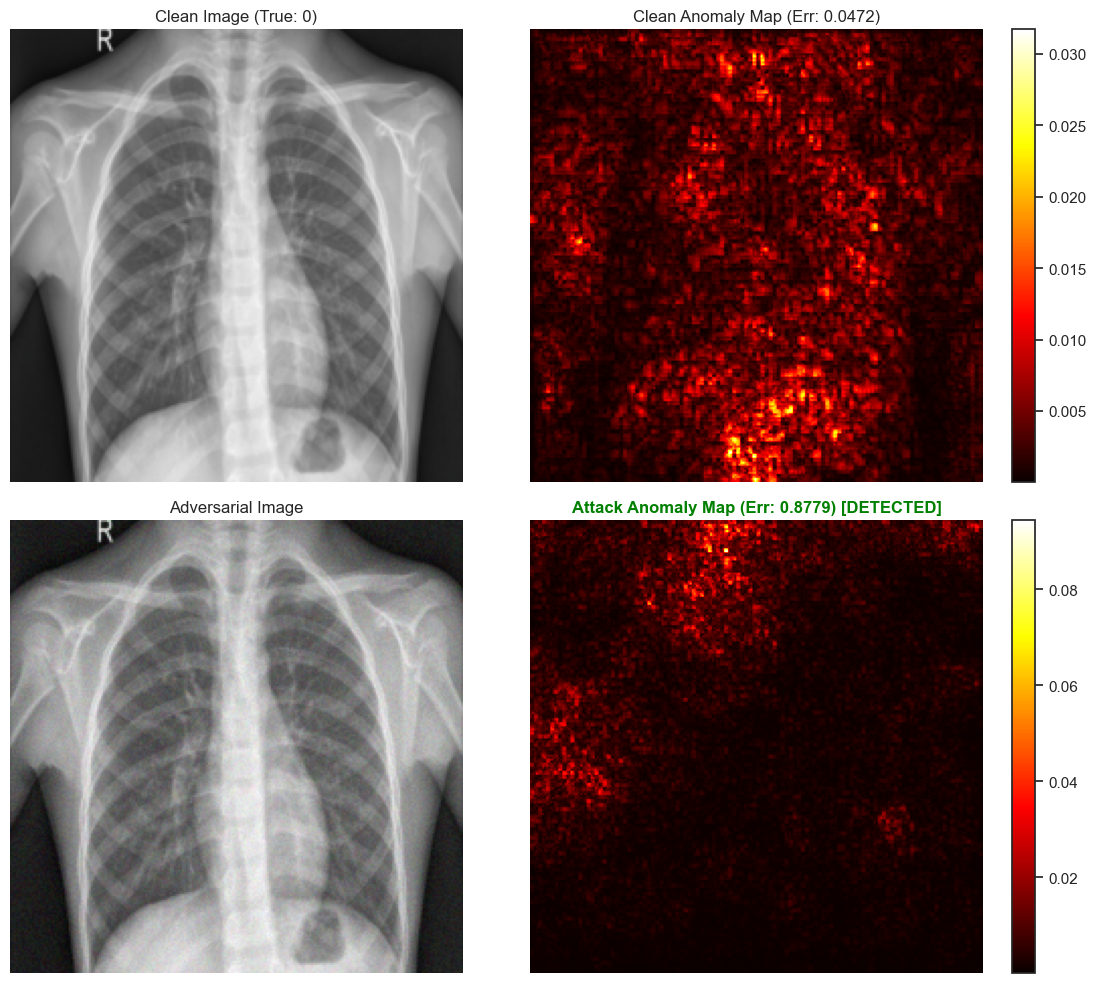

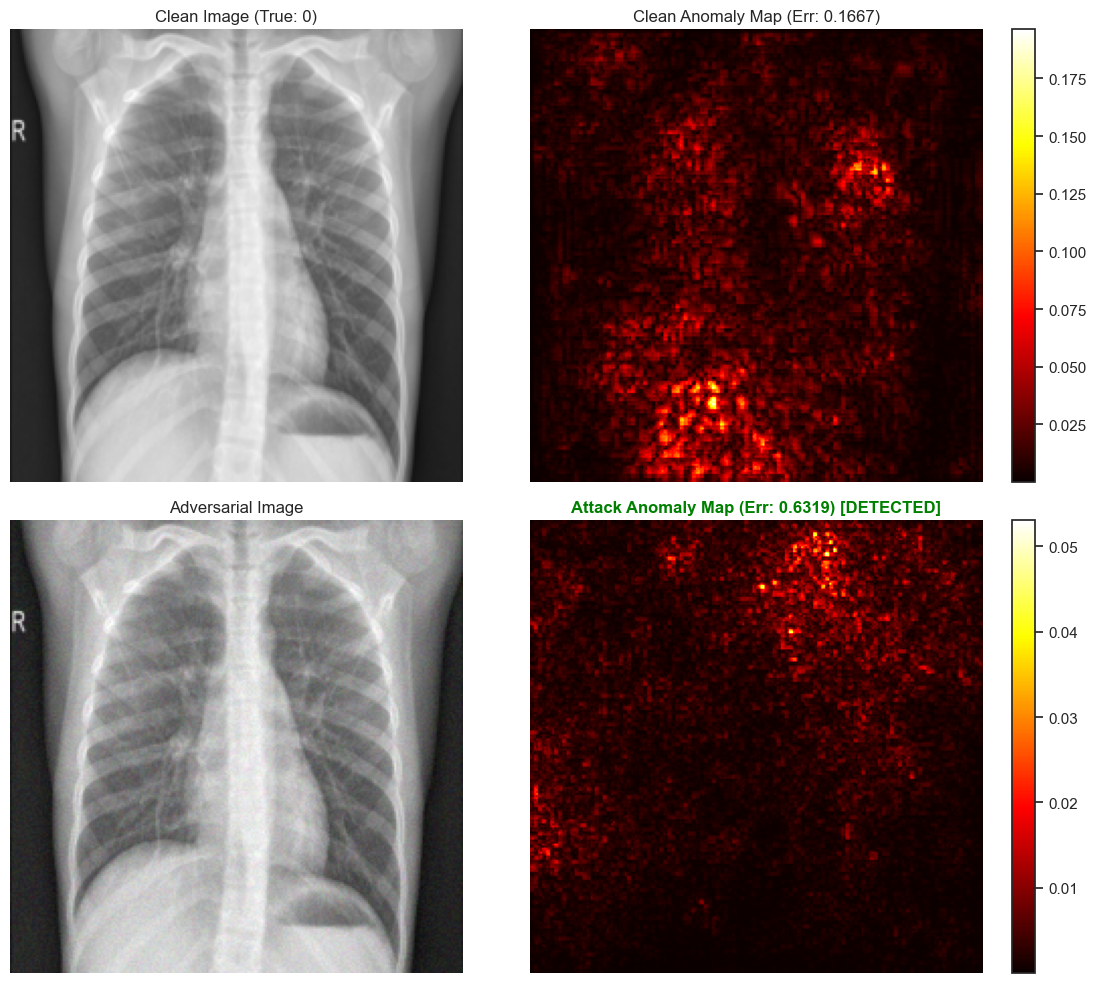

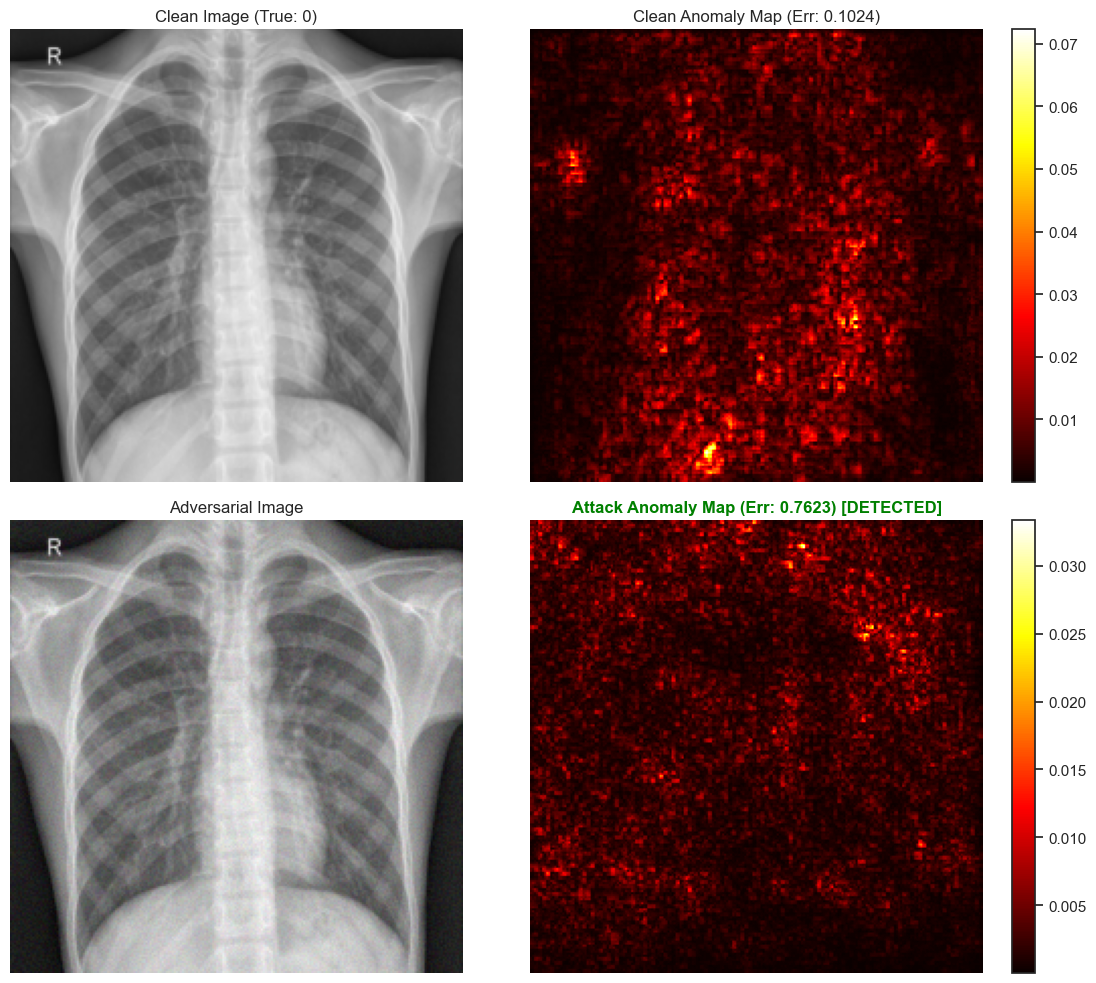

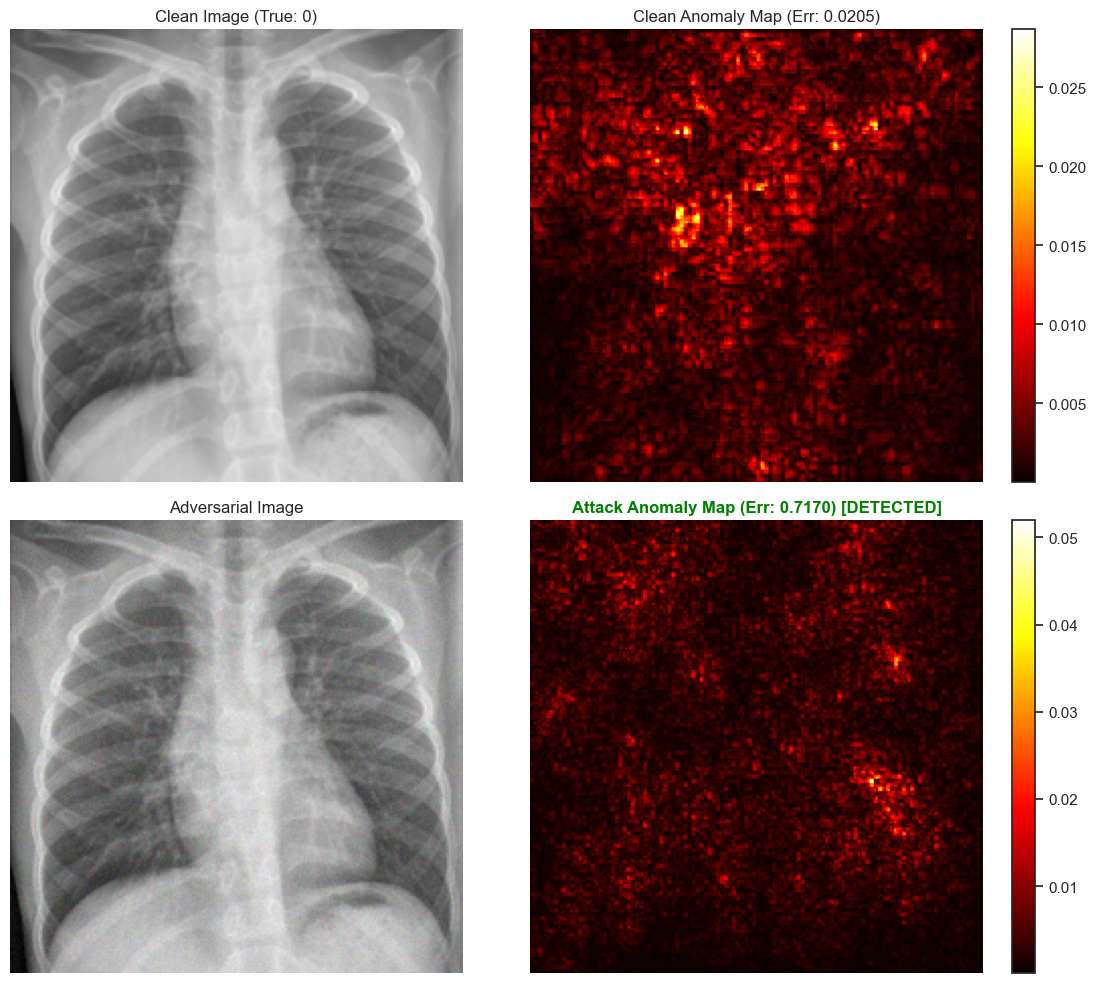

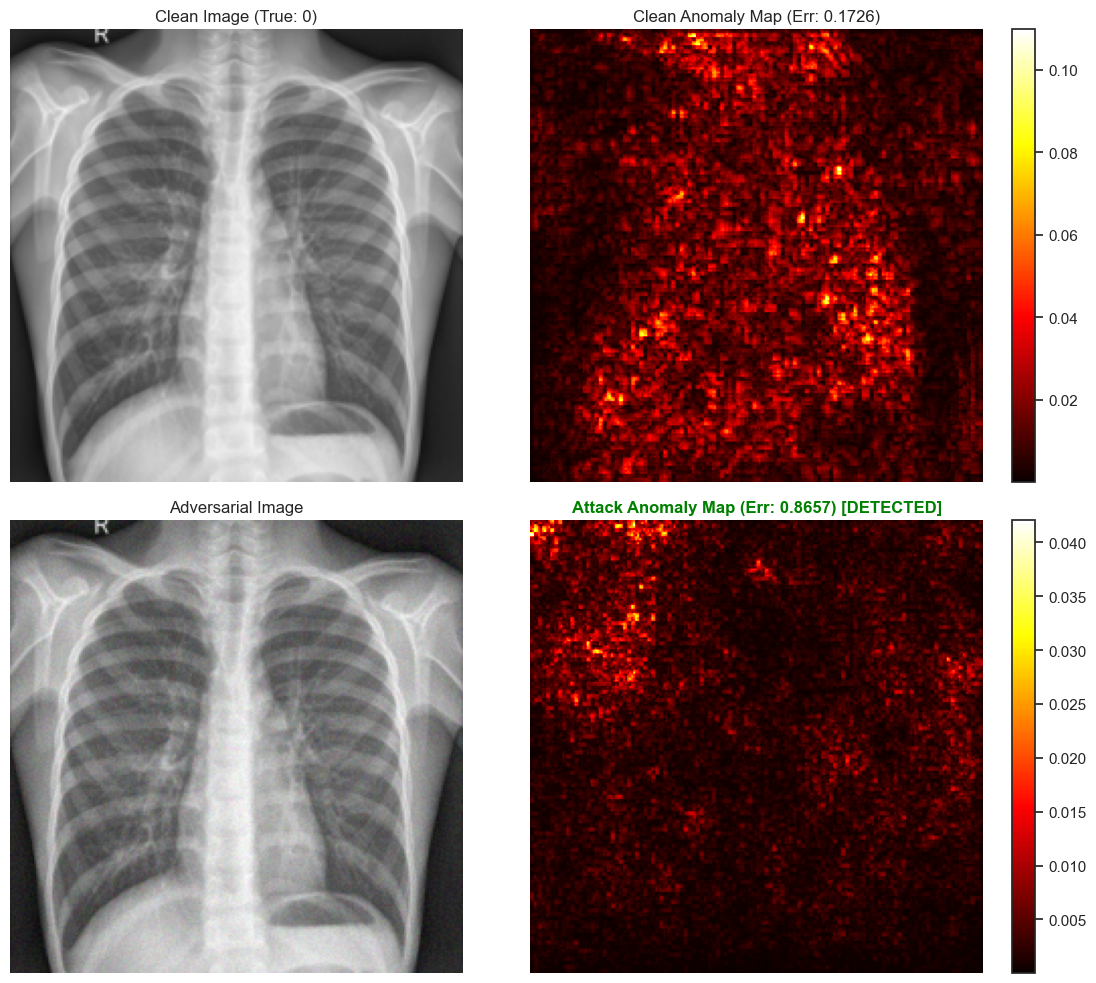

In [6]:
# Visualize first 5 samples
for i in range(5):
    visualize_detection(i)